In [1]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
import torchvision.transforms as trnsfrms
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:
transform = trnsfrms.Compose([
    trnsfrms.ToTensor(),
    trnsfrms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_x, train_y = torch.tensor(train_dataset.data).type(torch.float32).permute(0, 3, 1, 2), torch.tensor(train_dataset.targets)
test_x, test_y = torch.tensor(test_dataset.data).type(torch.float32).permute(0, 3, 1, 2), torch.tensor(test_dataset.targets)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([8, 3, 32, 32])


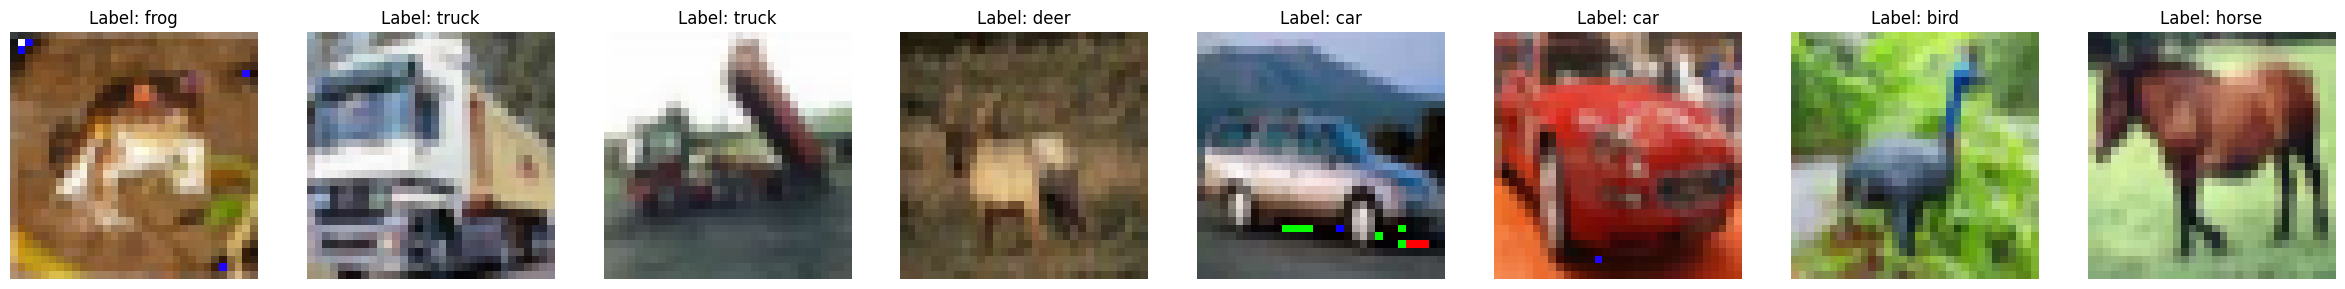

In [4]:
import PIL.ImageOps

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.view(x.size(0), -1)

def draw_sample(X, Y, num_images_to_show=5):
    print(X.shape)
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(30, 12))
    pil = ToPILImage()
    for i in range(num_images_to_show):
        image, label = X[i], Y[i]
        image = pil(image)
        inverted_image = PIL.ImageOps.invert(image)
        axes[i].imshow(inverted_image)
        axes[i].set_title(f"Label: {classes[label]}")
        axes[i].axis('off')

    plt.show()

def draw_samples(X, y):
    images, labels = X[0:8], y[0:8]
    draw_sample(images, labels, 8)
    

draw_samples(train_x, train_y)

In [5]:
def draw_heatmap(y_pred, y_true):
    with torch.no_grad():
        conf_matr = confusion_matrix(y_true, y_pred)
        classes = y_true.unique().tolist()
        dataframe = pd.DataFrame(conf_matr, index=classes, columns=classes)
        sns.heatmap(dataframe, annot=True, cbar=False, cmap="YlGnBu",fmt="d")

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, stride_conv, kernel_conv_size, out_channels, in_channels, use_batch_norm=True):
        super().__init__()
        if use_batch_norm:
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv, padding=1),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
            )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNet(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, kernel_conv_size, stride_pool=2, kernel_pool_size=2, out_channels=6, in_channels=3, lin_leyers=3):
        super().__init__()
        models = [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv)] + \
            [ResNetBlock(stride_conv, kernel_conv_size, out_channels, out_channels)] * num_of_blocks + \
            [nn.AvgPool2d(kernel_pool_size, stride=stride_pool), Flatten()]
        vect = torch.zeros(1, 3, 32, 32)
        for model in models:
            vect = model(vect)
        lin_dim = vect.shape[1]
        print(lin_dim)
        lin_dims = [lin_dim]
        for i in range(lin_leyers-1):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        lin_dims.append(10)
        self.model = nn.Sequential(
            *models,
            *[nn.Linear(lin_dims[i], lin_dims[i+1]) for i in range(len(lin_dims)-1)]
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {criterion(self(X[:5000]), Y[:5000])}')
                print(f'epoch {epoch} accuracy: {accuracy_score(Y[:5000], self.predict(X[:5000]))}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

1350
epoch 0 loss: 2.186732530593872
epoch 0 accuracy: 0.1758
epoch 1 loss: 2.0657424926757812
epoch 1 accuracy: 0.244
epoch 2 loss: 1.863224983215332
epoch 2 accuracy: 0.3338
epoch 3 loss: 1.7712270021438599
epoch 3 accuracy: 0.3692
epoch 4 loss: 2.013099193572998
epoch 4 accuracy: 0.2612
num of blocks: 1
1350
epoch 0 loss: 2.082141399383545
epoch 0 accuracy: 0.255
epoch 1 loss: 2.0695888996124268
epoch 1 accuracy: 0.2648
epoch 2 loss: 1.8449687957763672
epoch 2 accuracy: 0.3324
epoch 3 loss: 1.7811967134475708
epoch 3 accuracy: 0.361
epoch 4 loss: 1.6751902103424072
epoch 4 accuracy: 0.3986
num of blocks: 2
1350
epoch 0 loss: 2.304965019226074
epoch 0 accuracy: 0.1086
epoch 1 loss: 2.2970969676971436
epoch 1 accuracy: 0.1166
epoch 2 loss: 2.2899694442749023
epoch 2 accuracy: 0.1214
epoch 3 loss: 2.274623394012451
epoch 3 accuracy: 0.1282
epoch 4 loss: 2.218635320663452
epoch 4 accuracy: 0.1724
num of blocks: 3
[0.2494, 0.4008, 0.1688]
[0.2260900517541032, 0.3925192541241721, 0.151596

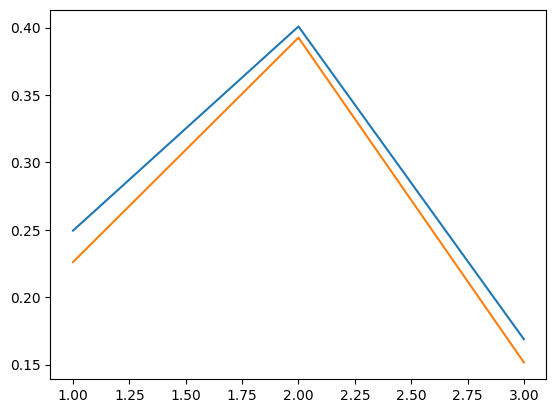

In [16]:
num_of_blocks = [1, 2, 3]
accuracy_scores = []
f1_scores = []
for num_of_block in num_of_blocks:
    model = ResNet(num_of_blocks=num_of_block, stride_conv=1, kernel_conv_size=3, out_channels=6, in_channels=3, lin_leyers=2)
    model.fit(train_x, train_y, epochs=5, lr=0.0005, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'num of blocks: {num_of_block}')
    accuracy_scores.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))

print(accuracy_scores)
print(f1_scores)
plt.plot(num_of_blocks, accuracy_scores)
plt.plot(num_of_blocks, f1_scores)
plt.show()

1350
epoch 0 loss: 2.2175204753875732
epoch 0 accuracy: 0.1718
epoch 1 loss: 2.101815938949585
epoch 1 accuracy: 0.232
epoch 2 loss: 1.9189574718475342
epoch 2 accuracy: 0.3192
epoch 3 loss: 1.8133177757263184
epoch 3 accuracy: 0.3546
epoch 4 loss: 1.7053478956222534
epoch 4 accuracy: 0.3972
num of channels: 6
2250
epoch 0 loss: 2.253199577331543
epoch 0 accuracy: 0.1438
epoch 1 loss: 2.206785202026367
epoch 1 accuracy: 0.1796
epoch 2 loss: 2.1159517765045166
epoch 2 accuracy: 0.2398
epoch 3 loss: 2.0001604557037354
epoch 3 accuracy: 0.2892
epoch 4 loss: 1.9393298625946045
epoch 4 accuracy: 0.3066
num of channels: 10
3600
epoch 0 loss: 1.860763669013977
epoch 0 accuracy: 0.3522
epoch 1 loss: 1.635873556137085
epoch 1 accuracy: 0.4276
epoch 2 loss: 1.5369038581848145
epoch 2 accuracy: 0.4538
epoch 3 loss: 1.5190954208374023
epoch 3 accuracy: 0.4652
epoch 4 loss: 1.4996834993362427
epoch 4 accuracy: 0.4786
num of channels: 16
5400
epoch 0 loss: 1.805308222770691
epoch 0 accuracy: 0.372
e

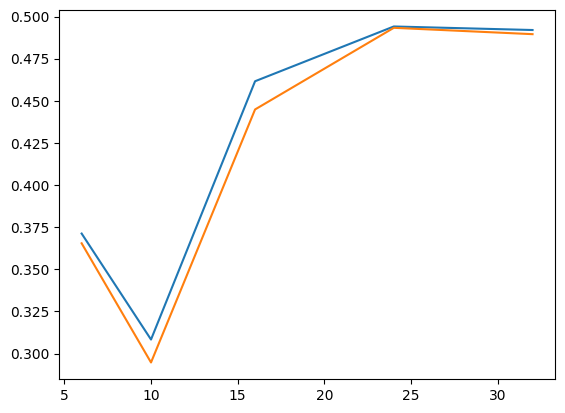

In [17]:
num_of_channels = [6, 10, 16, 24, 32]

accuracy_scores = []
f1_scores = []
for num_of_channel in num_of_channels:
    model = ResNet(num_of_blocks=1, stride_conv=1, kernel_conv_size=3, out_channels=num_of_channel, in_channels=3, lin_leyers=2)
    model.fit(train_x, train_y, epochs=5, lr=0.0005, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'num of channels: {num_of_channel}')
    accuracy_scores.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))

print(accuracy_scores)
print(f1_scores)
plt.plot(num_of_channels, accuracy_scores)
plt.plot(num_of_channels, f1_scores)
plt.show()

In [19]:
class ResNet2(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, kernel_conv_size, stride_pool=2, kernel_pool_size=2, out_channels=6, in_channels=3, lin_leyers=3):
        super().__init__()
        models = [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv)] + \
            [ResNetBlock(stride_conv, kernel_conv_size, out_channels, out_channels), nn.MaxPool2d(kernel_pool_size, stride=stride_pool)] * num_of_blocks + \
            [Flatten()]
        vect = torch.zeros(1, 3, 32, 32)
        for model in models:
            vect = model(vect)
        lin_dim = vect.shape[1]
        print(lin_dim)
        lin_dims = [lin_dim]
        for i in range(lin_leyers-1):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        lin_dims.append(10)
        self.model = nn.Sequential(
            *models,
            *[nn.Linear(lin_dims[i], lin_dims[i+1]) for i in range(len(lin_dims)-1)]
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {criterion(self(X[:5000]), Y[:5000])}')
                print(f'epoch {epoch} accuracy: {accuracy_score(Y[:5000], self.predict(X[:5000]))}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

1350
epoch 0 loss: 2.2804698944091797
epoch 0 accuracy: 0.1208
epoch 1 loss: 2.2368180751800537
epoch 1 accuracy: 0.1548
epoch 2 loss: 2.1801083087921143
epoch 2 accuracy: 0.2068
epoch 3 loss: 2.0850372314453125
epoch 3 accuracy: 0.2604
epoch 4 loss: 1.9524224996566772
epoch 4 accuracy: 0.307
epoch 5 loss: 1.8918836116790771
epoch 5 accuracy: 0.342
epoch 6 loss: 1.8264784812927246
epoch 6 accuracy: 0.365
epoch 7 loss: 1.8492915630340576
epoch 7 accuracy: 0.36
epoch 8 loss: 1.824090838432312
epoch 8 accuracy: 0.371
epoch 9 loss: 1.8004820346832275
epoch 9 accuracy: 0.3794
lr: 0.0005
0.3638
0.35866576363586056
1350
epoch 0 loss: 2.3108601570129395
epoch 0 accuracy: 0.0966
epoch 1 loss: 2.316211223602295
epoch 1 accuracy: 0.0964
epoch 2 loss: 2.2812106609344482
epoch 2 accuracy: 0.1238
epoch 3 loss: 2.2389111518859863
epoch 3 accuracy: 0.1462
epoch 4 loss: 2.2063403129577637
epoch 4 accuracy: 0.1622
epoch 5 loss: 2.181072950363159
epoch 5 accuracy: 0.1768
epoch 6 loss: 2.130718231201172
e

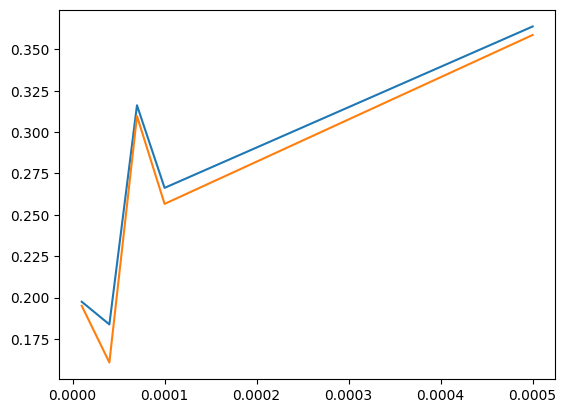

In [10]:
lrs = [0.0005, 0.0001, 0.00007, 0.00004, 0.00001]
accs = []
f1_scores = []

for lr in lrs:
    model = ResNet2(num_of_blocks=1, stride_conv=1, kernel_conv_size=3, out_channels=6, in_channels=3, lin_leyers=2)
    model.fit(train_x, train_y, epochs=10, lr=lr, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'lr: {lr}')
    accs.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))
    print(accuracy_score(test_y, preds))
    print(f1_score(test_y, preds, average='macro'))
    
plt.plot(lrs, accs)
plt.plot(lrs, f1_scores)
plt.show()

1350
epoch 0 loss: 2.2904934883117676
epoch 0 accuracy: 0.1344
epoch 1 loss: 2.2649664878845215
epoch 1 accuracy: 0.1486
epoch 2 loss: 2.214688301086426
epoch 2 accuracy: 0.1876
epoch 3 loss: 2.1728575229644775
epoch 3 accuracy: 0.2
epoch 4 loss: 2.1500275135040283
epoch 4 accuracy: 0.2168
epoch 5 loss: 2.1072452068328857
epoch 5 accuracy: 0.2302
epoch 6 loss: 2.078624725341797
epoch 6 accuracy: 0.2512
epoch 7 loss: 2.0563933849334717
epoch 7 accuracy: 0.2646
epoch 8 loss: 2.0307328701019287
epoch 8 accuracy: 0.2686
epoch 9 loss: 2.002410411834717
epoch 9 accuracy: 0.2836
num of blocks: 1
0.2854
0.270483144555512
294
epoch 0 loss: 2.4533650875091553
epoch 0 accuracy: 0.206
epoch 1 loss: 2.2054481506347656
epoch 1 accuracy: 0.2476
epoch 2 loss: 2.056549310684204
epoch 2 accuracy: 0.2658
epoch 3 loss: 1.9970232248306274
epoch 3 accuracy: 0.2984
epoch 4 loss: 1.9075731039047241
epoch 4 accuracy: 0.322
epoch 5 loss: 1.8965798616409302
epoch 5 accuracy: 0.3206
epoch 6 loss: 1.84364223480224

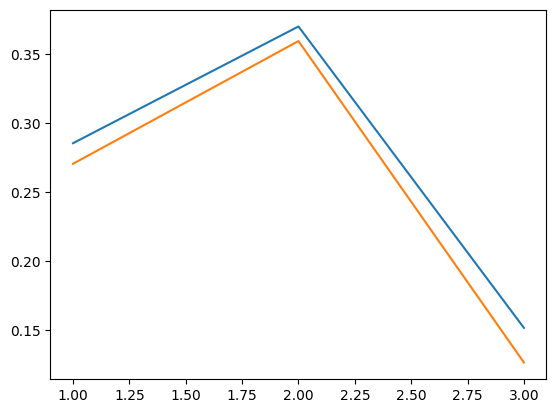

In [11]:
num_of_blocks = [1, 2, 3]
accs = []
f1_scores = []

for num_of_block in num_of_blocks:
    model = ResNet2(num_of_blocks=num_of_block, stride_conv=1, kernel_conv_size=3, out_channels=6, in_channels=3, lin_leyers=2)
    model.fit(train_x, train_y, epochs=10, lr=0.0001, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'num of blocks: {num_of_block}')
    accs.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))
    print(accuracy_score(test_y, preds))
    print(f1_score(test_y, preds, average='macro'))

plt.plot(num_of_blocks, accs)
plt.plot(num_of_blocks, f1_scores)
plt.show()

1350
epoch 0 loss: 2.3296799659729004
epoch 0 accuracy: 0.1114
epoch 1 loss: 2.3156216144561768
epoch 1 accuracy: 0.1056
epoch 2 loss: 2.3095948696136475
epoch 2 accuracy: 0.1184
epoch 3 loss: 2.304783344268799
epoch 3 accuracy: 0.1124
epoch 4 loss: 2.2999770641326904
epoch 4 accuracy: 0.1138
epoch 5 loss: 2.296889066696167
epoch 5 accuracy: 0.124
epoch 6 loss: 2.293484687805176
epoch 6 accuracy: 0.1206
epoch 7 loss: 2.285413980484009
epoch 7 accuracy: 0.1266
epoch 8 loss: 2.269360065460205
epoch 8 accuracy: 0.1388
epoch 9 loss: 2.2707715034484863
epoch 9 accuracy: 0.1388
num of lin layers: 1
0.1394
0.11565006209641551
1350
epoch 0 loss: 2.32943058013916
epoch 0 accuracy: 0.1204
epoch 1 loss: 2.2852365970611572
epoch 1 accuracy: 0.1362
epoch 2 loss: 2.2918505668640137
epoch 2 accuracy: 0.1308
epoch 3 loss: 2.2619364261627197
epoch 3 accuracy: 0.1468
epoch 4 loss: 2.2642035484313965
epoch 4 accuracy: 0.1552
epoch 5 loss: 2.2343451976776123
epoch 5 accuracy: 0.1656
epoch 6 loss: 2.220693

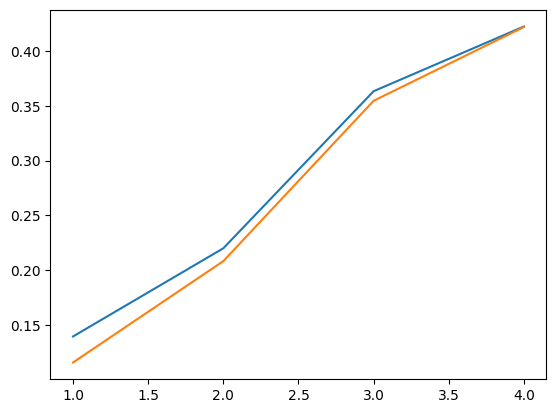

In [12]:
num_of_lin_layers = [1, 2, 3, 4]
accs = []
f1_scores = []

for num_of_lin_layer in num_of_lin_layers:
    model = ResNet2(num_of_blocks=1, stride_conv=1, kernel_conv_size=3, out_channels=6, in_channels=3, lin_leyers=num_of_lin_layer)
    model.fit(train_x, train_y, epochs=10, lr=0.0001, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'num of lin layers: {num_of_lin_layer}')
    accs.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))
    print(accuracy_score(test_y, preds))
    print(f1_score(test_y, preds, average='macro'))
    
plt.plot(num_of_lin_layers, accs)
plt.plot(num_of_lin_layers, f1_scores)
plt.show()
    

1350
epoch 0 loss: 2.2862796783447266
epoch 0 accuracy: 0.1676
epoch 1 loss: 2.2212977409362793
epoch 1 accuracy: 0.1902
epoch 2 loss: 2.141946792602539
epoch 2 accuracy: 0.2236
epoch 3 loss: 2.1034035682678223
epoch 3 accuracy: 0.247
epoch 4 loss: 2.074998378753662
epoch 4 accuracy: 0.268
epoch 5 loss: 1.959876537322998
epoch 5 accuracy: 0.3092
epoch 6 loss: 1.918500542640686
epoch 6 accuracy: 0.3266
epoch 7 loss: 1.881177544593811
epoch 7 accuracy: 0.3268
epoch 8 loss: 1.8570795059204102
epoch 8 accuracy: 0.3392
epoch 9 loss: 1.8146425485610962
epoch 9 accuracy: 0.3512
num of channels: 6
0.3458
0.3333660997028975
2250
epoch 0 loss: 2.274106025695801
epoch 0 accuracy: 0.1682
epoch 1 loss: 2.2134690284729004
epoch 1 accuracy: 0.2022
epoch 2 loss: 2.173413038253784
epoch 2 accuracy: 0.2106
epoch 3 loss: 2.1405603885650635
epoch 3 accuracy: 0.237
epoch 4 loss: 2.101839065551758
epoch 4 accuracy: 0.2536
epoch 5 loss: 2.067946672439575
epoch 5 accuracy: 0.2674
epoch 6 loss: 2.0134444236755

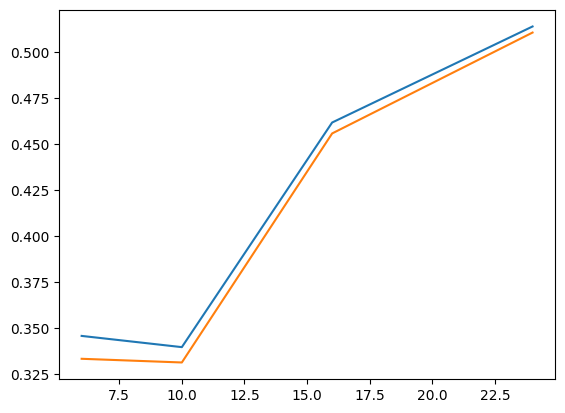

In [13]:
num_of_channels = [6, 10, 16, 24]

accs = []
f1_scores = []
for num_of_channel in num_of_channels:
    model = ResNet2(num_of_blocks=1, stride_conv=1, kernel_conv_size=3, out_channels=num_of_channel, in_channels=3, lin_leyers=2)
    model.fit(train_x, train_y, epochs=10, lr=0.0001, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'num of channels: {num_of_channel}')
    accs.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))
    print(accuracy_score(test_y, preds))
    print(f1_score(test_y, preds, average='macro'))

plt.plot(num_of_channels, accs)
plt.plot(num_of_channels, f1_scores)
plt.show()

216
epoch 0 loss: 2.1726508140563965
epoch 0 accuracy: 0.2268
epoch 1 loss: 2.004783868789673
epoch 1 accuracy: 0.2852
epoch 2 loss: 1.8906561136245728
epoch 2 accuracy: 0.3082
epoch 3 loss: 1.8208961486816406
epoch 3 accuracy: 0.3416
epoch 4 loss: 1.781419277191162
epoch 4 accuracy: 0.3558
epoch 5 loss: 1.7633830308914185
epoch 5 accuracy: 0.3688
epoch 6 loss: 1.7388384342193604
epoch 6 accuracy: 0.3726
epoch 7 loss: 1.721815586090088
epoch 7 accuracy: 0.3838
epoch 8 loss: 1.6949429512023926
epoch 8 accuracy: 0.388
epoch 9 loss: 1.6994658708572388
epoch 9 accuracy: 0.3908
0.4044
0.401941009896698


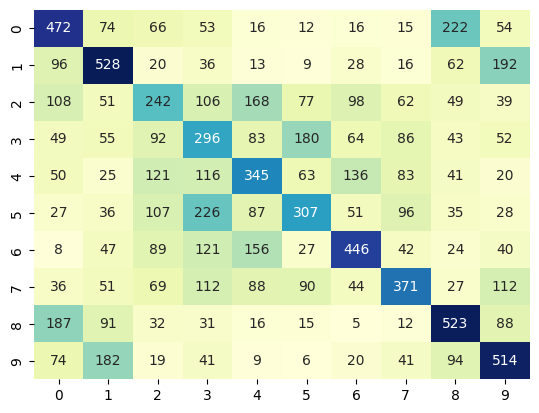

In [11]:
model = ResNet2(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=24, in_channels=3, lin_leyers=4)
model.fit(train_x, train_y, epochs=10, lr=0.00015, show_loss=True, show_period=1)

preds = model.predict(test_x)
print(accuracy_score(test_y, preds))
print(f1_score(test_y, preds, average='macro'))
draw_heatmap(preds, test_y)

1176
epoch 0 loss: 1.8607655763626099
epoch 0 accuracy: 0.3418
epoch 1 loss: 1.6925257444381714
epoch 1 accuracy: 0.3974
epoch 2 loss: 1.6275960206985474
epoch 2 accuracy: 0.4126
epoch 3 loss: 1.5468347072601318
epoch 3 accuracy: 0.4574
epoch 4 loss: 1.5122913122177124
epoch 4 accuracy: 0.476
epoch 5 loss: 1.4442901611328125
epoch 5 accuracy: 0.4918
epoch 6 loss: 1.458009123802185
epoch 6 accuracy: 0.4864
epoch 7 loss: 1.426649570465088
epoch 7 accuracy: 0.5012
epoch 8 loss: 1.3990509510040283
epoch 8 accuracy: 0.5054
epoch 9 loss: 1.360873818397522
epoch 9 accuracy: 0.52
0.5076
0.5020810989366609


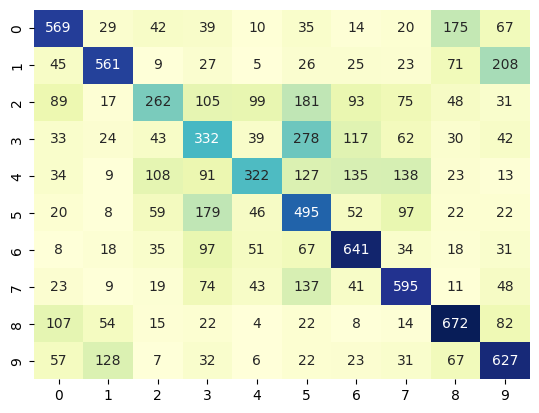

In [8]:
model = ResNet2(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=24, in_channels=3, lin_leyers=4)
model.fit(train_x, train_y, epochs=10, lr=0.00015, show_loss=True, show_period=1)

preds = model.predict(test_x)
print(accuracy_score(test_y, preds))
print(f1_score(test_y, preds, average='macro'))
draw_heatmap(preds, test_y)

In [ ]:
model = ResNet2(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=24, in_channels=3, lin_leyers=4)
model.fit(train_x, train_y, epochs=200, lr=0.00005, show_loss=True, show_period=1)

preds = model.predict(test_x)
print(accuracy_score(test_y, preds))
print(f1_score(test_y, preds, average='macro'))
draw_heatmap(preds, test_y)

216
epoch 0 loss: 2.6621615886688232
epoch 0 accuracy: 0.123
epoch 1 loss: 2.375545024871826
epoch 1 accuracy: 0.1772
epoch 2 loss: 2.262767791748047
epoch 2 accuracy: 0.2038
epoch 3 loss: 2.15673565864563
epoch 3 accuracy: 0.2416
epoch 4 loss: 2.1082186698913574
epoch 4 accuracy: 0.254
epoch 5 loss: 2.084350347518921
epoch 5 accuracy: 0.2664
epoch 6 loss: 1.996079683303833
epoch 6 accuracy: 0.302
epoch 7 loss: 1.9811118841171265
epoch 7 accuracy: 0.298
epoch 8 loss: 1.9462037086486816
epoch 8 accuracy: 0.3176
epoch 9 loss: 1.9205610752105713
epoch 9 accuracy: 0.3182
epoch 10 loss: 1.8867191076278687
epoch 10 accuracy: 0.3396
epoch 11 loss: 1.874607801437378
epoch 11 accuracy: 0.3446
epoch 12 loss: 1.8769384622573853
epoch 12 accuracy: 0.3348
epoch 13 loss: 1.8306844234466553
epoch 13 accuracy: 0.3606
epoch 14 loss: 1.8270320892333984
epoch 14 accuracy: 0.3516
epoch 15 loss: 1.8100683689117432
epoch 15 accuracy: 0.3672
epoch 16 loss: 1.751245141029358
epoch 16 accuracy: 0.3764
epoch 17

In [20]:

class ResNetBlock1(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)
    
class ResNetBlock2(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)
    
class ResNetBlock3(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNet3(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, kernel_conv_size, stride_pool=2, kernel_pool_size=2, out_channels=6, in_channels=3, lin_leyers=3, block=ResNetBlock1, pooling=nn.MaxPool2d):
        super().__init__()
        models = [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv)] + \
            [block(out_channels, out_channels)] * num_of_blocks + \
            [pooling(kernel_pool_size, stride=stride_pool), Flatten()]
        vect = torch.zeros(1, 3, 32, 32)
        for model in models:
            print(vect.shape)
            vect = model(vect)
        lin_dim = vect.shape[1]
        print(lin_dim)
        lin_dims = [lin_dim]
        for i in range(lin_leyers-1):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        lin_dims.append(10)
        self.model = nn.Sequential(
            *models,
            *[nn.Linear(lin_dims[i], lin_dims[i+1]) for i in range(len(lin_dims)-1)]
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        self.accs = []
        self.crits = []
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {criterion(self(X[:1000]), Y[:1000])}')
                print(f'epoch {epoch} accuracy: {accuracy_score(Y[:2000], self.predict(X[:2000]))}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

1372
epoch 0 loss: 1.7397520542144775
epoch 0 accuracy: 0.419
epoch 1 loss: 1.5614678859710693
epoch 1 accuracy: 0.457
epoch 2 loss: 1.4970484972000122
epoch 2 accuracy: 0.48
epoch 3 loss: 1.4270453453063965
epoch 3 accuracy: 0.5025
epoch 4 loss: 1.3491160869598389
epoch 4 accuracy: 0.5095
epoch 5 loss: 1.2396682500839233
epoch 5 accuracy: 0.551
epoch 6 loss: 1.2733991146087646
epoch 6 accuracy: 0.576
epoch 7 loss: 1.2322229146957397
epoch 7 accuracy: 0.561
epoch 8 loss: 1.245566487312317
epoch 8 accuracy: 0.5595
epoch 9 loss: 1.2904117107391357
epoch 9 accuracy: 0.5565
block: <class '__main__.ResNetBlock1'>
0.5476
0.5383009425716391
1372
epoch 0 loss: 1.6986017227172852
epoch 0 accuracy: 0.3835
epoch 1 loss: 1.598527193069458
epoch 1 accuracy: 0.404
epoch 2 loss: 1.474099040031433
epoch 2 accuracy: 0.4795
epoch 3 loss: 1.4336885213851929
epoch 3 accuracy: 0.4965
epoch 4 loss: 1.3215113878250122
epoch 4 accuracy: 0.5225
epoch 5 loss: 1.3791526556015015
epoch 5 accuracy: 0.5345
epoch 6 

TypeError: float() argument must be a string or a real number, not 'type'

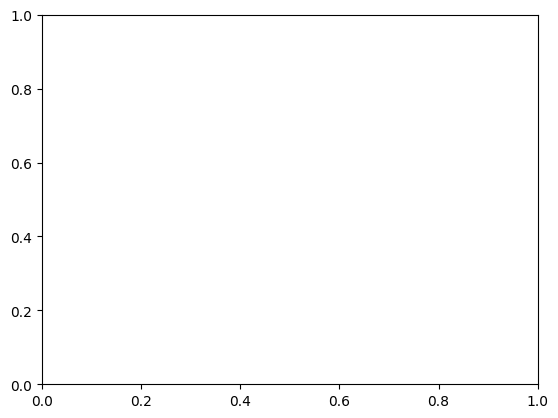

In [16]:
blocks = [ResNetBlock1, ResNetBlock2, ResNetBlock3]
accs = []
f1_scores = []

for block in blocks:
    model = ResNet3(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=28, in_channels=3, lin_leyers=6, block=block)
    model.fit(train_x, train_y, epochs=10, lr=0.0006, show_loss=True, show_period=1)

    preds = model.predict(test_x)
    print(f'block: {block}')
    accs.append(accuracy_score(test_y, preds))
    f1_scores.append(f1_score(test_y, preds, average='macro'))
    print(accuracy_score(test_y, preds))
    print(f1_score(test_y, preds, average='macro'))

plt.plot(blocks, accs)
plt.plot(blocks, f1_scores)
plt.show()

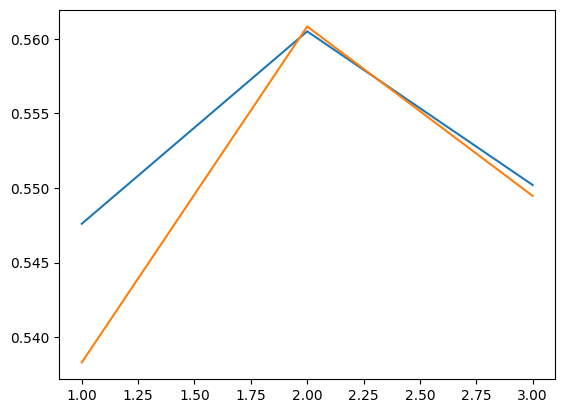

In [17]:
blocks = [1, 2, 3]
plt.plot(blocks, accs)
plt.plot(blocks, f1_scores)
plt.show()

1764
epoch 0 loss: 1.6680363416671753
epoch 0 accuracy: 0.421
epoch 1 loss: 1.5154677629470825
epoch 1 accuracy: 0.469
epoch 2 loss: 1.4139362573623657
epoch 2 accuracy: 0.5055
epoch 3 loss: 1.356773853302002
epoch 3 accuracy: 0.5195
epoch 4 loss: 1.3180327415466309
epoch 4 accuracy: 0.538
epoch 5 loss: 1.2471165657043457
epoch 5 accuracy: 0.5645
epoch 6 loss: 1.3083674907684326
epoch 6 accuracy: 0.5285
epoch 7 loss: 1.1545608043670654
epoch 7 accuracy: 0.585
epoch 8 loss: 1.1685922145843506
epoch 8 accuracy: 0.6075
epoch 9 loss: 1.170335054397583
epoch 9 accuracy: 0.5955
epoch 10 loss: 1.2190682888031006
epoch 10 accuracy: 0.592
epoch 11 loss: 1.1724436283111572
epoch 11 accuracy: 0.5895
epoch 12 loss: 1.1255695819854736
epoch 12 accuracy: 0.604
epoch 13 loss: 1.1085267066955566
epoch 13 accuracy: 0.613
epoch 14 loss: 1.049264669418335
epoch 14 accuracy: 0.631
epoch 15 loss: 1.0550860166549683
epoch 15 accuracy: 0.6235
epoch 16 loss: 1.0211254358291626
epoch 16 accuracy: 0.634
epoch 1

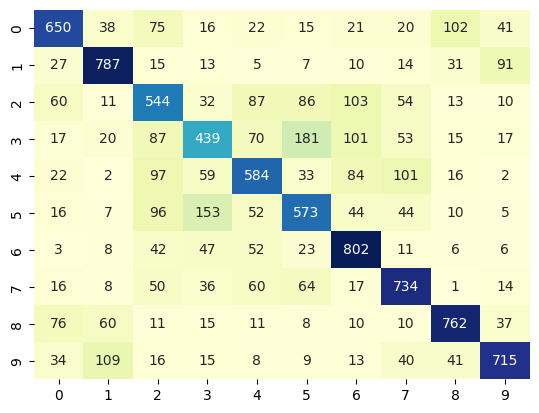

In [21]:
model = ResNet3(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=36, in_channels=3, lin_leyers=6, block=ResNetBlock2)
model.fit(train_x, train_y, epochs=100, lr=0.0006, show_loss=True, show_period=1)

preds = model.predict(test_x)
print(accuracy_score(test_y, preds))
print(f1_score(test_y, preds, average='macro'))
draw_heatmap(preds, test_y)

1764
epoch 0 loss: 1.7183918952941895
epoch 0 accuracy: 0.367
epoch 1 loss: 1.6178499460220337
epoch 1 accuracy: 0.429
epoch 2 loss: 1.5524530410766602
epoch 2 accuracy: 0.47
epoch 3 loss: 1.3826333284378052
epoch 3 accuracy: 0.4985
epoch 4 loss: 1.3250261545181274
epoch 4 accuracy: 0.508
epoch 5 loss: 1.3200571537017822
epoch 5 accuracy: 0.53
epoch 6 loss: 1.2768594026565552
epoch 6 accuracy: 0.5635
epoch 7 loss: 1.2601183652877808
epoch 7 accuracy: 0.5565
epoch 8 loss: 1.3011667728424072
epoch 8 accuracy: 0.549
epoch 9 loss: 1.2402477264404297
epoch 9 accuracy: 0.5645
epoch 10 loss: 1.2432371377944946
epoch 10 accuracy: 0.577
epoch 11 loss: 1.1756043434143066
epoch 11 accuracy: 0.5695
epoch 12 loss: 1.1276859045028687
epoch 12 accuracy: 0.592
epoch 13 loss: 1.2046453952789307
epoch 13 accuracy: 0.578
epoch 14 loss: 1.2045023441314697
epoch 14 accuracy: 0.5955
epoch 15 loss: 1.1662565469741821
epoch 15 accuracy: 0.6035
epoch 16 loss: 1.1073696613311768
epoch 16 accuracy: 0.6185
epoch 

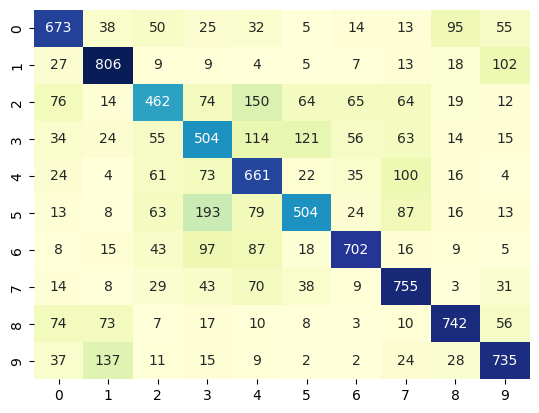

In [22]:
model = ResNet3(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=36, in_channels=3, lin_leyers=6, block=ResNetBlock2)
model.fit(train_x, train_y, epochs=100, lr=0.00045, show_loss=True, show_period=1)

preds = model.predict(test_x)
print(accuracy_score(test_y, preds))
print(f1_score(test_y, preds, average='macro'))
draw_heatmap(preds, test_y)

1764
epoch 0 loss: 1.6595228910446167
epoch 0 accuracy: 0.4265
epoch 1 loss: 1.469101071357727
epoch 1 accuracy: 0.4755
epoch 2 loss: 1.4322874546051025
epoch 2 accuracy: 0.502
epoch 3 loss: 1.3257375955581665
epoch 3 accuracy: 0.545
epoch 4 loss: 1.3693888187408447
epoch 4 accuracy: 0.53
epoch 5 loss: 1.3164305686950684
epoch 5 accuracy: 0.5485
epoch 6 loss: 1.2545571327209473
epoch 6 accuracy: 0.5745
epoch 7 loss: 1.2306687831878662
epoch 7 accuracy: 0.574
epoch 8 loss: 1.1865606307983398
epoch 8 accuracy: 0.5865
epoch 9 loss: 1.2661421298980713
epoch 9 accuracy: 0.56
epoch 10 loss: 1.1863458156585693
epoch 10 accuracy: 0.584
epoch 11 loss: 1.1385127305984497
epoch 11 accuracy: 0.604
epoch 12 loss: 1.1305056810379028
epoch 12 accuracy: 0.6015
epoch 13 loss: 1.1561230421066284
epoch 13 accuracy: 0.6015
epoch 14 loss: 1.067539095878601
epoch 14 accuracy: 0.6275
epoch 15 loss: 1.0930122137069702
epoch 15 accuracy: 0.634
epoch 16 loss: 1.0959283113479614
epoch 16 accuracy: 0.625
epoch 17

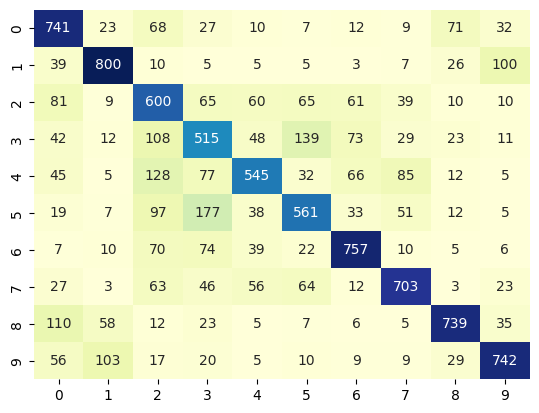

In [23]:
model = ResNet3(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=36, in_channels=3, lin_leyers=6, block=ResNetBlock2)
model.fit(train_x, train_y, epochs=150, lr=0.0006, show_loss=True, show_period=1)

preds = model.predict(test_x)
print(accuracy_score(test_y, preds))
print(f1_score(test_y, preds, average='macro'))
draw_heatmap(preds, test_y)

In [10]:
import torchvision.datasets.mnist as mnist
transform = trnsfrms.Compose([
    trnsfrms.ToTensor(),
    trnsfrms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_set =  mnist.MNIST('./data', download=True, train=True, transform=transform)
full_test_set = mnist.MNIST('./data', download=True, train=False, transform=transform)
full_train_x, full_train_y = full_train_set.data.reshape(-1, 1, 28, 28).type(torch.float32), full_train_set.targets
full_test_x, full_test_y = full_test_set.data.reshape(-1, 1, 28, 28).type(torch.float32), full_test_set.targets

digit_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_ind = [i for i, label in enumerate(full_train_y) if label in digit_labels]
test_ind = [i for i, label in enumerate(full_test_y) if label in digit_labels]

dig_train_x, dig_train_y = full_train_x[train_ind], full_train_y[train_ind]
dig_test_x, dig_test_y = full_test_x[test_ind], full_test_y[test_ind]

torch.Size([8, 1, 28, 28])


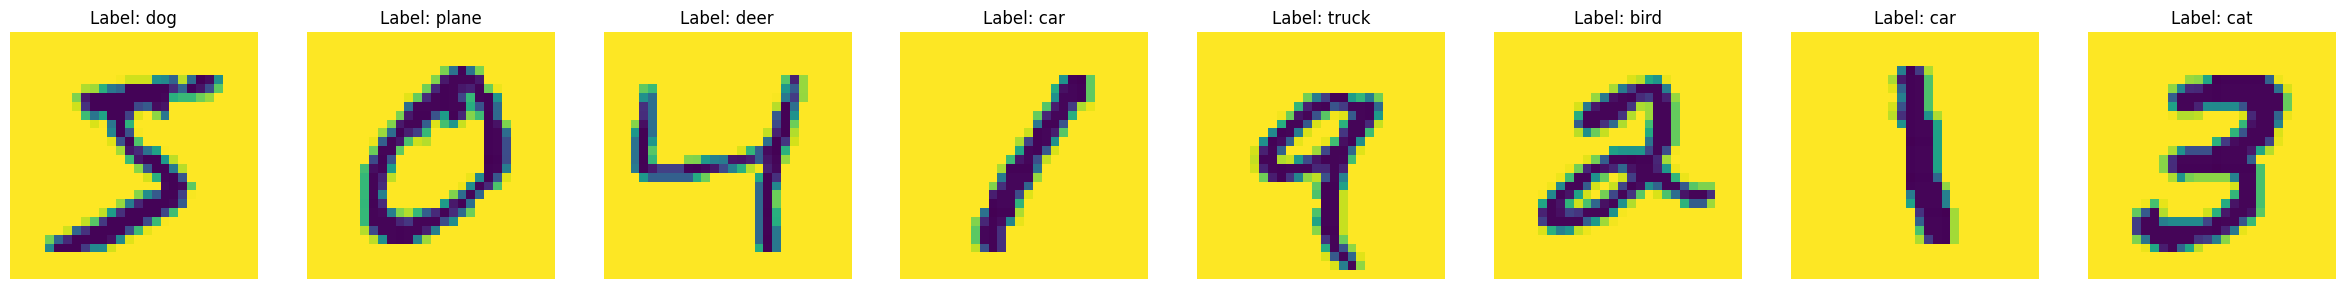

In [9]:
draw_samples(dig_train_x, dig_train_y)

In [11]:
class ResNetBlock4(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNet4(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, kernel_conv_size, stride_pool=2, kernel_pool_size=2, out_channels=6, in_channels=1, lin_leyers=3, block=ResNetBlock4, pooling=nn.MaxPool2d):
        super().__init__()
        models = [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv)] + \
            [block(out_channels, out_channels), 
             pooling(kernel_pool_size, stride=stride_pool)] * num_of_blocks + \
            [Flatten()]
        vect = torch.zeros(1, 1, 28, 28)
        for model in models:
            print(vect.shape)
            vect = model(vect)
        lin_dim = vect.shape[1]
        print(lin_dim)
        lin_dims = [lin_dim]
        for i in range(lin_leyers-1):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        lin_dims.append(10)
        self.model = nn.Sequential(
            *models,
            *[nn.Linear(lin_dims[i], lin_dims[i+1]) for i in range(len(lin_dims)-1)]
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {criterion(self(X[:1000]), Y[:1000])}')
                print(f'epoch {epoch} accuracy: {accuracy_score(Y[:2000], self.predict(X[:2000]))}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

In [12]:
print(dig_test_x.shape)

torch.Size([10000, 1, 28, 28])


In [13]:
model = ResNet4(num_of_blocks=2, stride_conv=1, kernel_conv_size=3, out_channels=36, in_channels=1, lin_leyers=6)
model.fit(dig_train_x, dig_train_y, epochs=10, lr=0.0006, show_loss=True, show_period=1)


torch.Size([1, 1, 28, 28])
torch.Size([1, 36, 26, 26])
torch.Size([1, 36, 26, 26])
torch.Size([1, 36, 13, 13])
torch.Size([1, 36, 13, 13])
torch.Size([1, 36, 6, 6])
1296
epoch 0 loss: 0.23669371008872986
epoch 0 accuracy: 0.9325
epoch 1 loss: 0.1990206092596054
epoch 1 accuracy: 0.9465
epoch 2 loss: 0.16731703281402588
epoch 2 accuracy: 0.9545
epoch 3 loss: 0.136550173163414
epoch 3 accuracy: 0.9595
epoch 4 loss: 0.13149946928024292
epoch 4 accuracy: 0.9585
epoch 5 loss: 0.10601150244474411
epoch 5 accuracy: 0.9705
epoch 6 loss: 0.08330854028463364
epoch 6 accuracy: 0.973
epoch 7 loss: 0.10650400817394257
epoch 7 accuracy: 0.9715
epoch 8 loss: 0.0835413783788681
epoch 8 accuracy: 0.975
epoch 9 loss: 0.0993821769952774
epoch 9 accuracy: 0.9655


0.9746
0.9745072041314324


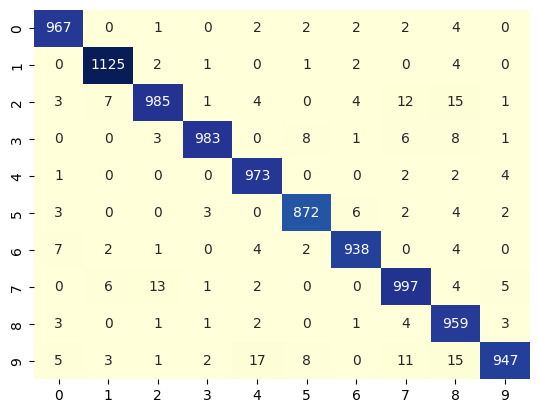

In [19]:
preds = model.predict(dig_test_x)
print(accuracy_score(dig_test_y, preds))
print(f1_score(dig_test_y, preds, average='macro'))
draw_heatmap(preds, dig_test_y)